# Pokemon

## Import lib & modules

In [1]:
import os
import pandas as pd
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim

In [2]:
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import random_split, DataLoader

## Custom Dataset

In [3]:
class PokemonDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
        # Convert Type1 to numeric labels
        self.classes = self.data["Type1"].unique()
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]["Name"] + ".png"
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")

        label_name = self.data.iloc[idx]["Type1"]
        label = self.class_to_idx[label_name]

        if self.transform:
            image = self.transform(image)

        return image, label

## Transforms

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

## Load Dataset

In [5]:
dataset = PokemonDataset(
    csv_file="pokemon.csv",
    img_dir="images",
    transform=transform
)

print("Number of classes:", len(dataset.classes))

Number of classes: 18


## Train / Validation Split

In [6]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Model 

In [7]:
class PokemonCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, len(dataset.classes))
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

## Device + Initialize

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PokemonCNN(len(dataset.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## FULL Training + Validation Loop

In [9]:
train_losses = []
val_losses = []

epochs = 10

for epoch in range(epochs):

    # -------- TRAIN --------
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # -------- VALIDATION --------
    model.eval()
    val_running_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print("-"*30)

Epoch 1/10
Train Loss: 2.7438
Val Loss: 2.6314
------------------------------
Epoch 2/10
Train Loss: 2.7003
Val Loss: 2.5997
------------------------------
Epoch 3/10
Train Loss: 2.5544
Val Loss: 2.7088
------------------------------
Epoch 4/10
Train Loss: 2.5318
Val Loss: 2.5696
------------------------------
Epoch 5/10
Train Loss: 2.4343
Val Loss: 2.5568
------------------------------
Epoch 6/10
Train Loss: 2.2627
Val Loss: 2.6249
------------------------------
Epoch 7/10
Train Loss: 2.1733
Val Loss: 2.7419
------------------------------
Epoch 8/10
Train Loss: 1.9800
Val Loss: 2.9142
------------------------------
Epoch 9/10
Train Loss: 1.7619
Val Loss: 2.9793
------------------------------
Epoch 10/10
Train Loss: 1.4697
Val Loss: 3.5354
------------------------------


## plots

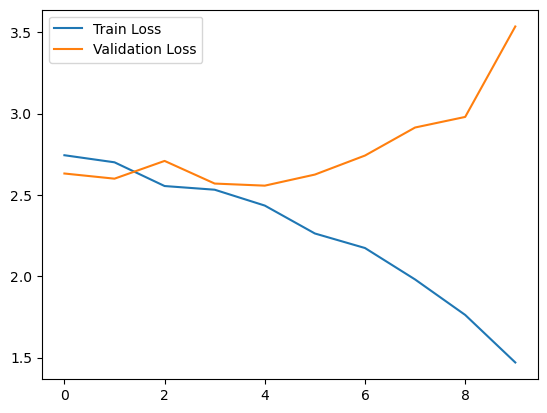

In [10]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.show()

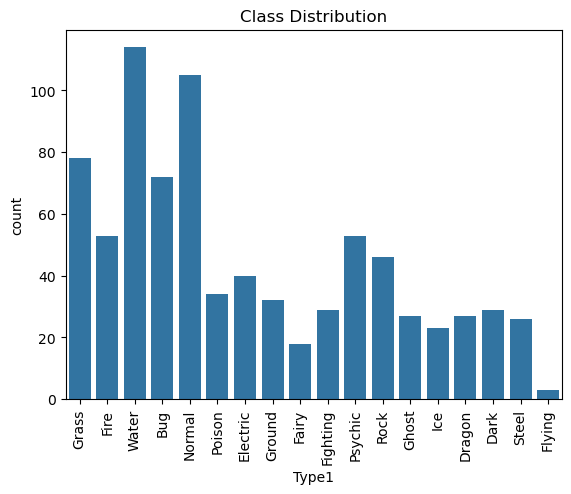

In [11]:
df = pd.read_csv("pokemon.csv")
sns.countplot(x=df["Type1"])
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.show()

## Evaluate

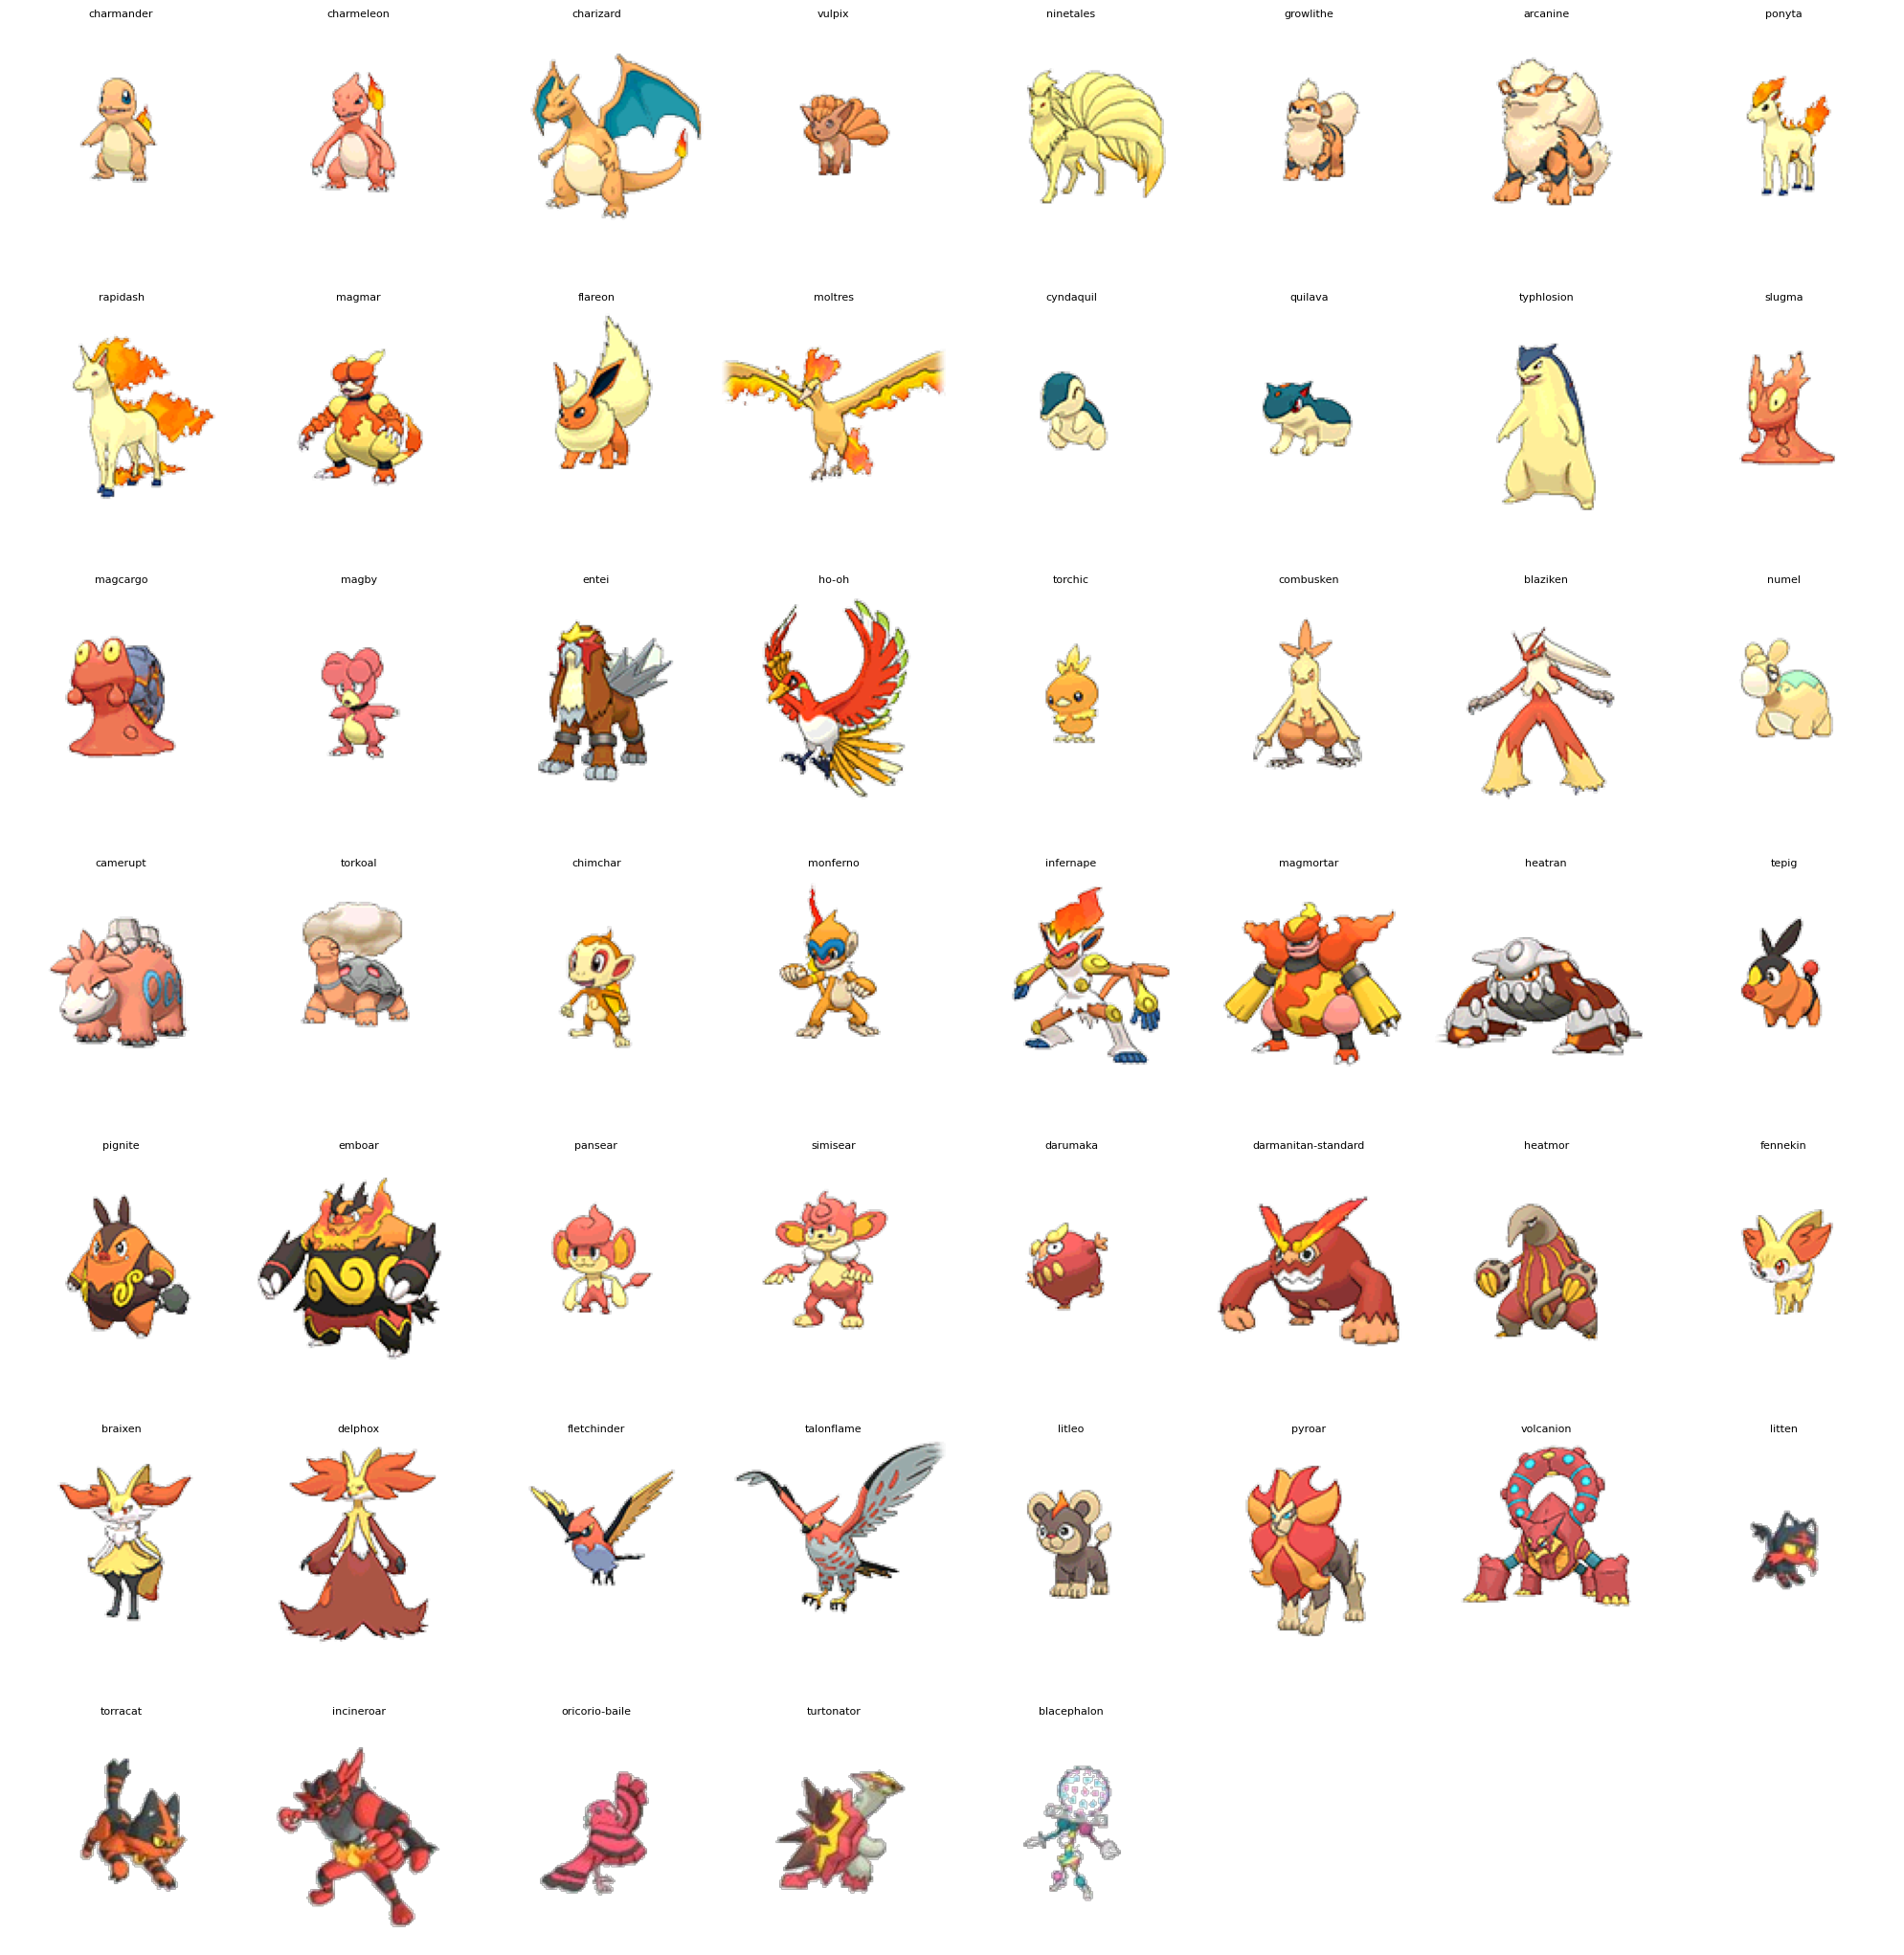

In [12]:
import math
fire_df = df[df["Type1"] == "Fire"]
num_images = len(fire_df)
cols = 8
rows = math.ceil(num_images / cols)

plt.figure(figsize=(20, rows * 3))

for i, (_, row) in enumerate(fire_df.iterrows()):
    img_path = os.path.join("images", row["Name"] + ".png")

    if not os.path.exists(img_path):
        continue

    img = Image.open(img_path)

    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.title(row["Name"], fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

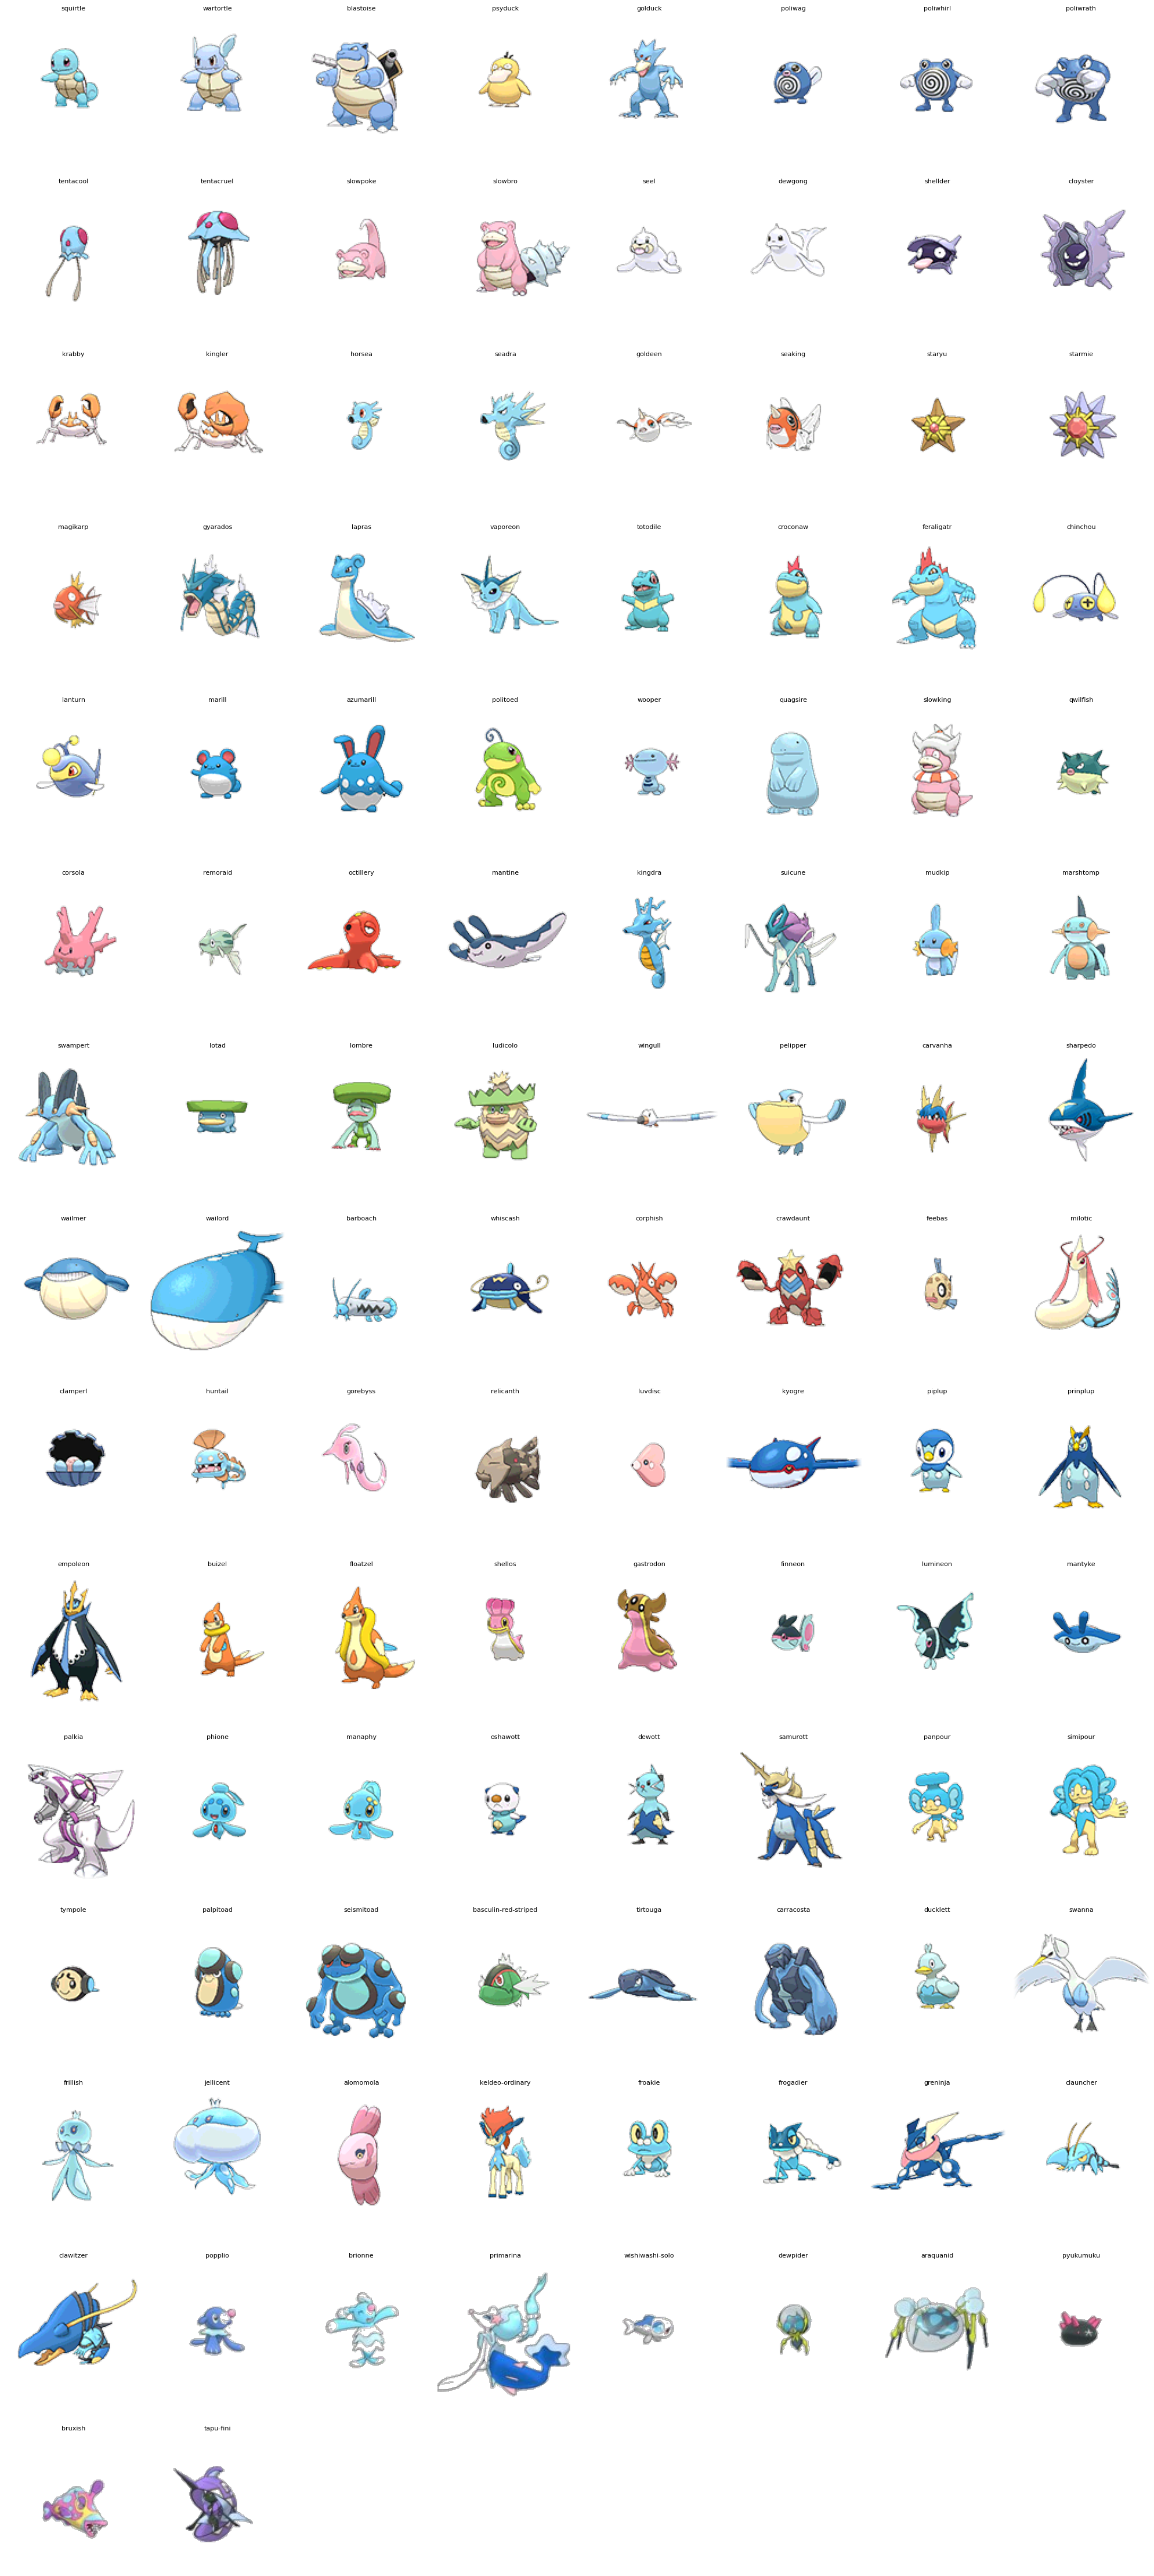

In [13]:
water_df = df[df["Type1"] == "Water"]
num_images = len(water_df)
cols = 8
rows = math.ceil(num_images / cols)

plt.figure(figsize=(20, rows * 3))

for i, (_, row) in enumerate(water_df.iterrows()):
    img_path = os.path.join("images", row["Name"] + ".png")

    if not os.path.exists(img_path):
        continue

    img = Image.open(img_path)

    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.title(row["Name"], fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()